<a href="https://colab.research.google.com/github/Bolorooo24/CV-ML_labs/blob/main/Pytorch-deep-learning/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. Pytorch Transfer Learning

What is transfer learning?

Transfer learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem.

* Pretrained model = foundation models.


In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.9.0+cu128
0.24.0+cu128


Now we've go the version of torch and torchvision, let;s import the code we've written in previous sections so that we don't have to write it all again.

In [2]:
# regular import
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# try to get torchinfo, install it if it doesn't work

try:
  from torchinfo import summary
except:
  print("info : coundn't find torvhinfo.. installing it")
  !pip install -q torchinfo
  from torchinfo import summary

# try to import the going_modular directory, download it from github if it doesn't work
try:
  from going_modular.going_modular import data_setup, engine

except:
  # get the going_modular scripts
  print("info: cound't find going_modular scripts .. downloading them from github")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

info : coundn't find torvhinfo.. installing it
info: cound't find going_modular scripts .. downloading them from github
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4410, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 4410 (delta 5), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4410/4410), 764.18 MiB | 15.72 MiB/s, done.
Resolving deltas: 100% (2661/2661), done.
Updating files: 100% (248/248), done.


In [3]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [4]:
!nvidia-smi

Fri Feb 13 04:09:50 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get Data

We need our pizza steak sushi data.

In [5]:
import os
import zipfile

from pathlib import Path

import requests


# setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from the dataset

# if the image folder doesn't exitst, download it

if image_path.is_dir():
  print("The image directory already exists, skipping download.")
else:
  print(f"Did not find {image_path}")
  image_path.mkdir(parents=True, exist_ok = True)


  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:

    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data ...")
    f.write(request.content)

  with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zipfile:
    print("Unzipping the data ")
    zipfile.extractall(image_path)

  # remove .zip file
  os.remove(data_path/"pizza_steak_sushi.zip")





Did not find data/pizza_steak_sushi
Unzipping the data 


In [6]:
# setup directory path
train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create datasets and dataloaders

Next step is turn data into Pytorch dataloaders

To do so, we can use `data_setup.py` and the `create_dataloaders()` function we made in chapter 5.


There's one hting we have to think about when lading: how ot **transform** it?

And with `torchvision` 0.13+ there's two ways to do this:

1. Manually created transforms - you define what transforms you want your data to go through
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.

Important point: when using a pretrained model, it's important that the data (including your custom data) that you pass through it is **transormed** in the same way that the data the model was trained on.


In [7]:
from going_modular.going_modular import data_setup



### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`

> All pretrained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3xHxW), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0,1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.224]. You can use the following transform to normalize.

In [8]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # resize image to 224, 224
    transforms.ToTensor(), # get images into range [0,1]
    normalize # make sure images have the same distribution as ImageNet (where our pretrianed models have been trained)
])

In [9]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                                batch_size = 32)

train_dataloader, test_dataloader, class_names



(<torch.utils.data.dataloader.DataLoader at 0x7bd91660a000>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a tranform for `torchvision.models` (auto creation)

As of +13 torchvision, there is now support for automatic data transform creation based on the pretrained model weights you're using

In [10]:
import torchvision
torchvision.__version__

'0.24.0+cu128'

In [11]:
# get aset of pretrained model weights

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # Default = best performing weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [12]:
# get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [13]:
# create dataloaders using aumatic transforms

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = auto_transforms,
    batch_size = 32
)
train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x7bd91660bc20>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model such as:
1. PyTorch domain libraries
2. Lib like `timm` (torch image models)
3. HuggingFace Hub (for models across different problem scpaces/domains)
4. Paperswithcode (for models across different problem spaces/domains)

### 3.1 Which pretrained model should you use?

*Experiment, experiment, experiment!*

The whole idea of transfer learning : take an already well-performing model from a problem space silimar to your own and then customize to your own problem.

3 things to consider:
1. Speed -how fast does it run?
2. Size - how big is the model?
3. Performance - how well does it go on your problem?

Where does the model live?

Is it on device?
Or does it live on a server?

Looking at https://docs.pytorch.org/vision/main/models.html

Which model should we choose?

For our case(deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of our best options in terms performance vs size.

However, in light of the Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could.

### 3.2 Setting up a pretrained model

Want to creaet an instance of a pretrained EfficientNetB0

https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0

In [14]:
# old method of creating a pretraine model prior to torchvision v0.13

model = torchvision.models.efficientnet_b0(pretrained=True)

# new method of creating a pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 50.8MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [16]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [17]:
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width])
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our need

With a feature extractor model, typically you will "freeze" the base layers of a pretrained/foundation model and update the outptu layers to suit your own problem.

In [18]:
# freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False

In [19]:
# update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # feature vector coming in
              out_features=len(class_names))).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [20]:
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width])
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# 4.0 Train model

In [21]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)


In [22]:
# import train function
from going_modular.going_modular import engine

# set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start timer
from timeit import default_timer as timer
start_time = timer()

# setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)
# end the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 11.841 seconds


## 5. Evaluate model by plotting loss curve


couldn't find helper_function.py, downloading ...


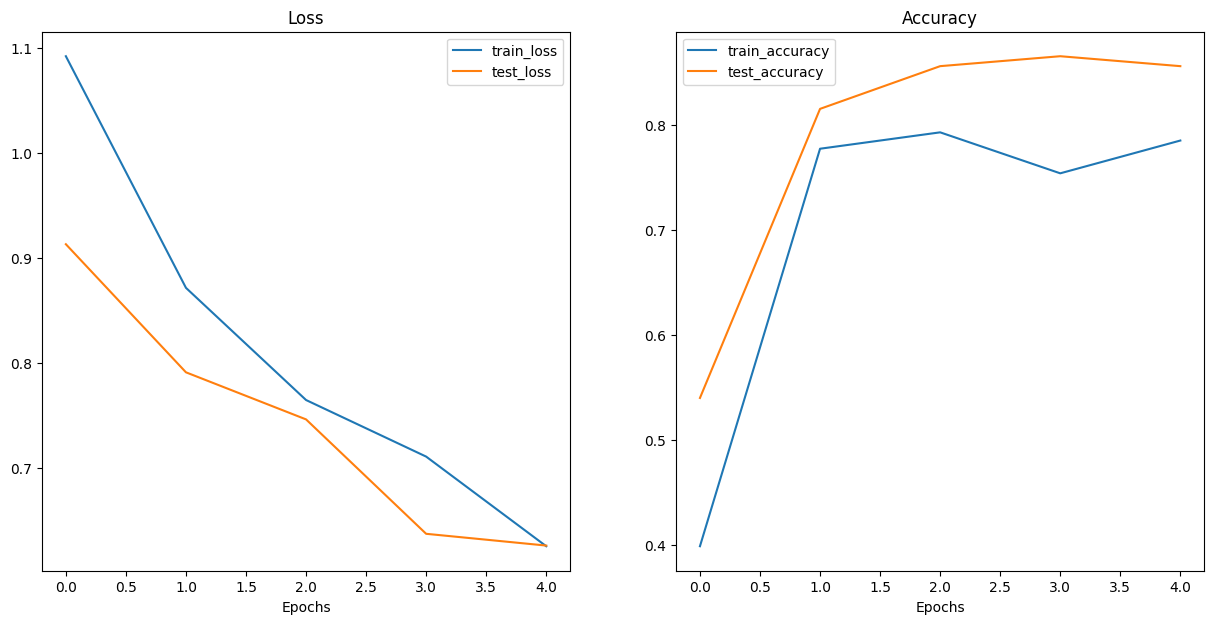

In [23]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"couldn't find helper_function.py, downloading ...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

  # plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

Let's adhere to the data explorer's motto of "visualize,,,,"

And make some qualitiative predictions on our test set.

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure that our test/custom data is:
* Same shape - images need to be same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device - custom data/test data shoudl be on the same device as the model
* Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same


To do all of this automagically, let's create a function called `pred_and_plot_image()`

The function will be similar to the one in the previous code.

1. Take in a trained model, a list of calss names, a filepath to a target image, an image size, a transform anda target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exit
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimension is suited for the model (this mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Conver the model's output logits to prediction probs usin `torch.softmax()`
9. Convert model's prediction probs to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probs from step 8



In [24]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model...
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str],
    image_size: Tuple[int, int] = (244, 244),
    transform: torchvision.transforms=None,
    device: torch.device = device):
  # 2. open the image with PIL
  img = Image.open(image_path)

  # 3. create transform
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])
    ])

  # 4. make sure the model on the target device
  model.to(device)

  # 5. turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    # 6. transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_size, color_channels, height, width]

    # 7. make a prediction on the transformed image by passing it to the model and ensure the target device
    target_image_pred = model(transformed_image.to(device))

  # 8. convert the model's output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 9. convert the model's pred probs to pred labels
  target_image_pred_labels = torch.argmax(target_image_pred_probs, dim =1)

  # 10. plot image with predicted label and prob
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_labels]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);


In [25]:
import random
import os

# get a random list of image paths the test set
def get_random_images(dataset_dir: str,
                      number_of_images: int):
  image_files = []
  if dataset_dir:
    for root, dirs, files in os.walk(dataset_dir):
      for file in files:
        img_path = os.path.join(root,file)
        image_files.append(img_path)
    random_images = random.choices(image_files, k=number_of_images)
    return random_images



In [26]:
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample  = random.sample(population=test_image_path_list,
                                        k=num_images_to_plot)
test_image_path_sample

[PosixPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg')]

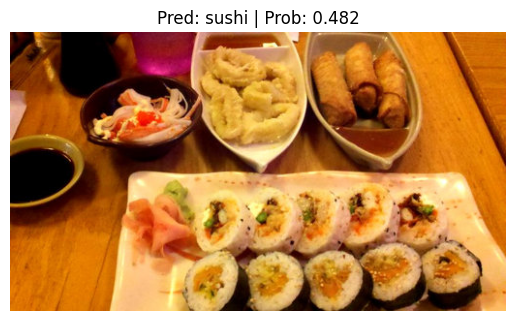

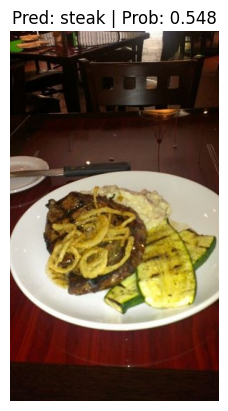

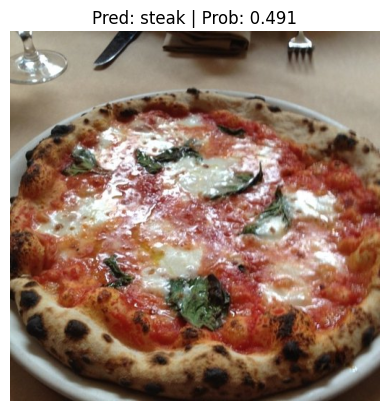

In [27]:
random_images = get_random_images(test_dir, 3)

for image_path in random_images:
  pred_and_plot_image(
      model=model,
      image_path = image_path,
      class_names = class_names,
      image_size=(244,244)
  )

### 6.1 Making prediction on a custom image

let's make prediction on the pizza dad image: https://github.com/mrdbourke/pytorch-deep-learning/blob/baa27b691617461c173ecf3439793cd8cde74e13/images/04-pizza-dad.jpeg


In [33]:
import requests

custom_image_path = data_path/ "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading ...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download ...")


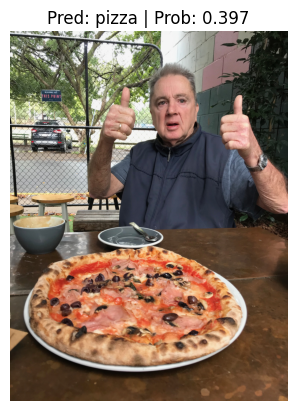

In [34]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)